## Unsupervised learning: dimensionality reduction

In [321]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
import xarray as xr

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from cartopy.feature import NaturalEarthFeature

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [322]:
#Open data
DATADIR = '/Users/noeliaotero/Documents/OCCR/data/data_CAS_ML/'
mslp = xr.open_mfdataset(DATADIR + 'Daymean_era5_2deg_MSL_EU_19790101-20210902.nc', combine='by_coords')
# Convert to hPa
mslp.MSL.values = mslp.MSL.values/100
lon = mslp.lon
lat = mslp.lat

In [323]:
mslp.MSL.shape

(15555, 25, 41)

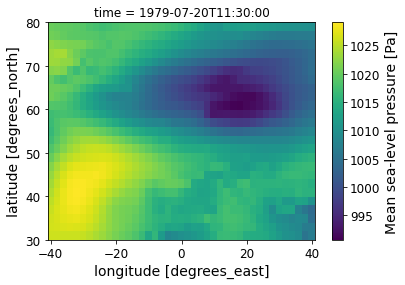

In [324]:
# plot an example (day) of mslp
mslp.MSL.isel(time=200).plot();

In [325]:
#monthly_means = mslp.groupby("time.month").mean()
seas_means = mslp.groupby("time.season").mean()

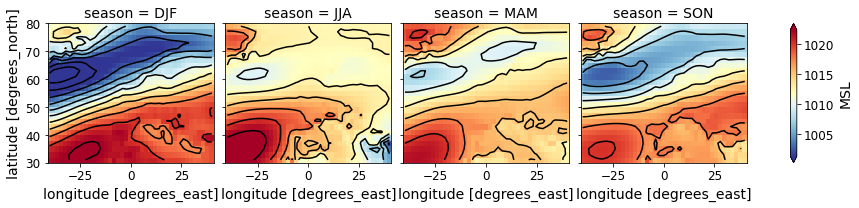

In [326]:
fg = seas_means.MSL.plot(col="season",  col_wrap=4,
    # The remaining kwargs customize the plot just as for not-faceted plots
    robust=True,
    cmap=mpl.cm.RdYlBu_r)

# Use this to plot contours on each panel
# Note that this plotting call uses the original DataArray gradients
fg.map_dataarray(
    xr.plot.contour, x="lon", y="lat", colors="k", levels=13, add_colorbar=False
)

# Starting the analysis
1. Calculate anomalies (input for PCA?)

In [327]:
# compute anomalies
climatology = mslp.mean('time')
# By season
season_climatology = mslp.groupby('time.season').mean('time')


In [328]:
# climatological anomalies
anom_mslp = anom_mslp.MSL  - climatology
# By season
anom_seas_mslp = mslp.groupby('time.season') - season_climatology

2. PCA

In [329]:
# start using the whole data set for PCA. Then, anomalies can be used
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [330]:
# Some studies used scale-weighted by the latitude 
weights = np.cos(np.deg2rad(mslp.lat))
weights.name = "weights"
r_weights = np.sqrt(weights)
data_mean = mslp.mean()
# Normalised by the weights from the cosine of the latitude
mslp_weights = (mslp - data_mean) / r_weights

In [331]:
# We need to reshape the data [time,latxlon]  
mslp_weights_stacked = mslp_weights.stack(latlon=('lat', 'lon'))

In [332]:
# We need to reshape the data [time,latxlon]  
mslp_stacked = mslp.stack(latlon=('lat', 'lon'))

In [333]:
# Load in memory for computing the PCA

In [334]:
mslp_weights_stacked.load()

<xarray.Dataset>
Dimensions:  (latlon: 1025, time: 15555)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T11:30:00 ... 2021-09-02T10:00:00
  * latlon   (latlon) MultiIndex
  - lat      (latlon) float64 31.0 31.0 31.0 31.0 31.0 ... 79.0 79.0 79.0 79.0
  - lon      (latlon) float64 -40.0 -38.0 -36.0 -34.0 ... 34.0 36.0 38.0 40.0
Data variables:
    MSL      (time, latlon) float64 1.201 1.521 1.394 ... -0.8571 -2.125 -3.267

In [335]:
mslp_stacked.load()

<xarray.Dataset>
Dimensions:    (bnds: 2, latlon: 1025, time: 15555)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01T11:30:00 ... 2021-09-02T10:00:00
  * latlon     (latlon) MultiIndex
  - lat        (latlon) float64 31.0 31.0 31.0 31.0 31.0 ... 79.0 79.0 79.0 79.0
  - lon        (latlon) float64 -40.0 -38.0 -36.0 -34.0 ... 34.0 36.0 38.0 40.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 1979-01-01 ... 2021-09-02T21:00:00
    MSL        (time, latlon) float32 1.014e+03 1.015e+03 ... 1.012e+03
Attributes:
    CDI:          Climate Data Interface version 1.9.9rc1 (https://mpimet.mpg...
    Conventions:  CF-1.6
    history:      Thu Sep 09 09:01:32 2021: cdo mergetime Day_era5_2deg_MSL_E...
    institution:  European Centre for Medium-Range Weather Forecasts
    frequency:    day
    CDO:          Climate Data Operators version 1.9.9rc1 (https://mpimet.mpg...

In [336]:
type(mslp_stacked)
X = mslp_stacked.MSL
XW = mslp_weights_stacked.MSL

In [337]:
# The number of variables (features) is 1025 (41 points in longitude * 25 points in latitude)
# Standardise the data
from sklearn.preprocessing import StandardScaler
scaler  = StandardScaler()
scaler = scaler.fit(X)
X = scaler.transform(X)

In [338]:
X

array([[-1.3662041 , -1.3372065 , -1.3799026 , ..., -0.4053013 ,
        -0.43174243, -0.45912445],
       [-0.39594698, -0.5584062 , -0.6909078 , ..., -0.3751896 ,
        -0.42766413, -0.46781546],
       [ 0.72596586,  0.6920604 ,  0.6105696 , ...,  0.13993634,
         0.09191863,  0.04219088],
       ...,
       [-1.1190876 , -1.0642639 , -0.94796085, ..., -0.24773388,
        -0.22686455, -0.20301254],
       [ 0.04226418, -0.06516903, -0.24823172, ..., -0.04761949,
        -0.07696676, -0.10273619],
       [ 0.38998473,  0.31639245,  0.15550782, ...,  0.20126969,
         0.15498872,  0.11355335]], dtype=float32)

In [339]:
XW

<xarray.DataArray 'MSL' (time: 15555, latlon: 1025)>
array([[  1.20075   ,   1.52081376,   1.39417267, ..., -17.35103153,
        -18.12581829, -18.92813129],
       [  6.747445  ,   5.95503175,   5.29980751, ..., -16.53223074,
        -18.01459552, -19.16580708],
       [ 13.16111394,  13.07475276,  12.67735949, ...,  -2.52486865,
         -3.84459109,  -5.21852764],
       ...,
       [  2.61344747,   3.07485349,   3.84267688, ..., -13.06643981,
        -12.53841111, -11.92417079],
       [  9.25257842,   8.76335223,   7.8091601 , ...,  -7.62490772,
         -8.45041541,  -9.18188677],
       [ 11.24040178,  10.9358303 ,  10.09779724, ...,  -0.85708602,
         -2.12455052,  -3.26695927]])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T11:30:00 ... 2021-09-02T10:00:00
  * latlon   (latlon) MultiIndex
  - lat      (latlon) float64 31.0 31.0 31.0 31.0 31.0 ... 79.0 79.0 79.0 79.0
  - lon      (latlon) float64 -40.0 -38.0 -36.0 -34.0 ... 34.0 36.0 38.0 40.0

In [340]:
#pca = PCA(n_components = 4) # start with 4 
pca = PCA()
pca.fit(X)

PCA()

In [341]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

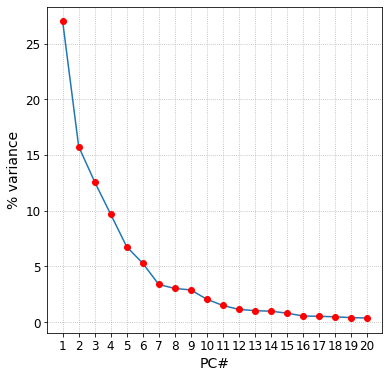

In [342]:
# See how many components 
f, ax = plt.subplots(figsize=(6,6))
ax.plot(range(1,21), pca.explained_variance_ratio_[0:20]*100)
ax.plot(range(1,21), pca.explained_variance_ratio_[0:20]*100,'ro')
ax.grid(ls=':')
ax.set_xticks(range(1,21)); 
ax.set_xlabel('PC#');
ax.set_ylabel("% variance");

In [343]:
# We can take 4 or 5
# Following the literature I will take 4 (e.g. Cortesi et a., 2021)
n = 5
pca.explained_variance_ratio_[:n].sum()

0.71724933

In [344]:
# Additional checks
# pca = PCA(n_components=0.95)
# X_reduced = pca.fit_transform(X)
# I will beed to incllude 18 PC to get 95% 
# pca.n_components_

In [345]:
PCs = pca.fit_transform(X)
PCs_n = PCs[:,:n]

In [350]:
# Data frame format for the selected components
PCdf = pd.DataFrame(PCs_n, index = mslp['time'], \
                    columns = ["PC%s" % (x) for x in range(1, PCs_n.shape[1] +1)])
# see the data
PCdf.head()

,PC1,PC2,PC3,PC4,PC5
1979-01-01 11:30:00,-16.388954,11.987208,-5.626942,1.106520,-1.336235
1979-01-02 11:30:00,-17.707638,3.619361,-6.970998,4.755789,-11.374031
1979-01-03 11:30:00,-13.251805,3.883414,-1.273765,0.620562,-8.590654
1979-01-04 11:30:00,-15.760413,0.768828,-0.849967,-7.507794,1.703121
1979-01-05 11:30:00,3.909627,-9.706419,-8.834671,-14.672668,11.592632


The EOFS (Empirical orthogonal functions) contain the spatial patterns associated with each PC


In [351]:
EOFs = pca.components_
EOFs = EOFs[:n,:]
EOFs.shape

# EOFs_r = EOFs.reshape((ipc, len(lat), len(lon)))

(5, 1025)

In [361]:
# reshape the data
EOFs_r = EOFs.reshape((n, len(lat), len(lon)))
EOFs_r.shape
pca.explained_variance_ratio_.sum()

1.0000001

In [364]:
nn = []
for ip in range(n):
    xn = pca.explained_variance_ratio_[:ip + 1].sum()
    nn.append(xn)

In [363]:
nn

[0.7301947, 0.5726775, 0.44692767, 0.35027587, 0.2827508]

In [354]:
# Convert into Xarray for visualization
#nn = [0,1,2,3,4]
XD_EOFs_r = xr.DataArray(data=EOFs_r, coords=[("PCA", nn), ("lat", lat), ("lon", lon)])

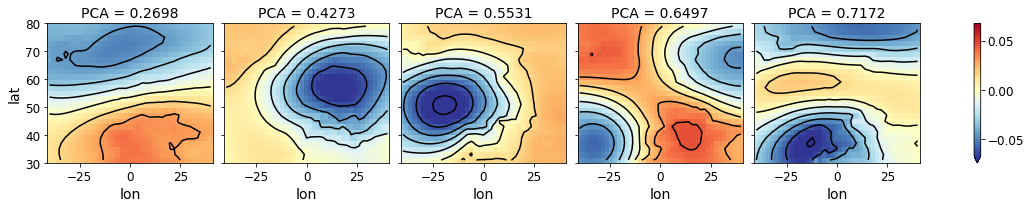

In [355]:
fg = XD_EOFs_r.plot(col="PCA",  col_wrap=5,
    # The remaining kwargs customize the plot just as for not-faceted plots
    robust=True,
    cmap=mpl.cm.RdYlBu_r)

# Use this to plot contours on each panel
# Note that this plotting call uses the original DataArray gradients
fg.map_dataarray(
    xr.plot.contour, x="lon", y="lat", colors="k", levels=13, add_colorbar=False
)

# K-Cluster analysis

In [365]:
from sklearn.cluster import KMeans

In [ ]:
# Perform K-cluster analysis using the PCds obtained before
